## Set variables

In [1]:
dataset_path = './data/gtzan'
diraudiofiles = f"{dataset_path}/genres_3sec"
features_path = f'{dataset_path}/features'
melspec_path = f'{features_path}/melspecs_3sec'
test_dir = f'{dataset_path}/test1'

In [2]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [3]:
# model_name_or_path = "m3hrdadfi/wav2vec2-base-100k-gtzan-music-genres"
model_name_or_path = "models/wav2vec2-base-100k-gtzan-music-genres"

## Genre classifier using wav2wec2 

In [4]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [5]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Use pretrained wav2vec2 model to predict genre

We are using a pretrained model uploaded to Huggingface. Maybe we should train a model ourselves?

In [7]:
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate

In [10]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [11]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

## Model evaluation on test set

In [28]:
import numpy as np
import librosa
import torchaudio
from datasets import load_dataset, load_metric
from sklearn.metrics import classification_report

In [13]:
test_dataset = load_dataset("csv", data_files={"test": f"{dataset_path}/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-b0b880de4f45f458


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\ACER\.cache\huggingface\datasets\csv\default-b0b880de4f45f458\0.0.0\50d3f5d1aef1732094f95566e0c67506165deea4ff693f78b1a17588fb6bc108. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'label'],
    num_rows: 200
})

In [22]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), orig_sr=sampling_rate, target_sr=feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = feature_extractor(batch["speech"], sampling_rate=feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [23]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/200 [00:00<?, ?ex/s]

In [24]:
result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/25 [00:00<?, ?ba/s]

In [25]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [29]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       blues       0.79      0.95      0.86        20
   classical       0.86      0.95      0.90        20
     country       0.81      0.65      0.72        20
       disco       0.78      0.70      0.74        20
      hiphop       0.93      0.70      0.80        20
        jazz       1.00      0.85      0.92        20
       metal       0.78      0.90      0.84        20
         pop       0.92      0.55      0.69        20
      reggae       0.54      0.95      0.69        20
        rock       0.61      0.55      0.58        20

    accuracy                           0.78       200
   macro avg       0.80      0.78      0.77       200
weighted avg       0.80      0.78      0.77       200



## Predict genres of manually curated songs

These audiofiles are preprocessed to be of the same properties as the GTZAN dataset, i.e.,

- sampling rate = 22050
- no of channels = 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Label": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs

In [11]:
test_dir = f'{dataset_path}/genres_test'
songs = 'Taylor_Swift_Love_Story'
songs += ' Nirvana_Smells_Like_Teen_Spirit'
songs += ' Green_Day_American_Idiot'
songs = songs.split()

In [12]:
preds = None

for song in songs:
    path = f'{test_dir}/{song}.wav'
    scores = predict(path, sampling_rate)

    if preds is None:
        preds = scores
    else:
        preds = np.vstack([preds, scores])

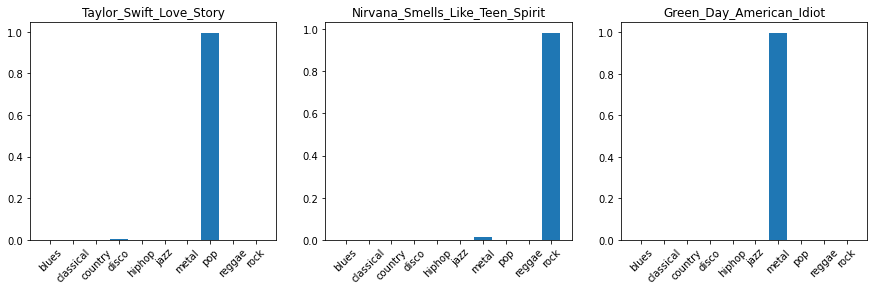

In [13]:
fig,ax = plt.subplots(1,len(songs),figsize=(15,4))

for i in range(len(songs)):
    ax[i].bar(x=genres,height=preds[i])
    ax[i].tick_params('x', labelrotation=45)
    ax[i].set_title(f'{songs[i]}')
    
plt.show()